In [68]:
import pandas as pd
from tensorflow.keras import regularizers   
from tensorflow.keras.layers import Dense, Activation, Dropout 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, auc, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt 
import email
import numpy as np
import re

In [2]:
train_df = pd.read_csv('data/Train_data.csv')
test_df = pd.read_csv('data/Test_data.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16130 entries, 0 to 16129
Data columns (total 2 columns):
Label    16130 non-null object
Text     16130 non-null object
dtypes: object(2)
memory usage: 252.2+ KB


In [4]:
train_df.head(10)

,Label,Text
0,CLOS_DISC,Closing DisclosureThis form is a statement of ...
1,CLOS_DISC,Closing Cost DetailsBorrower-PaidSeller-PaldLo...
2,CLOS_DISC,Calculating Cash to CloseUse this table to see...
3,CLOS_DISC,Additiona Information About This LoanLoan Disc...
4,CLOS_DISC,Loan CalculationsOther DisclosuresTotal of Pay...
5,NOTE,TCOPYOF THENOTEHARRINGTONLoan #: 1217172251Ser...
6,NOTE,01050624181217172251then: (a) any such loan ch...
7,NOTE,01050624181217172251This Note is a uniform ins...
8,MORTGAGE,After Recording Return To:UNITED SHORE FINANCI...
9,MORTGAGE,"01050624181217172251(H) ""Riders"" means all Rid..."


In [5]:
train_df.dtypes

Label    object
Text     object
dtype: object

In [6]:
def clean(text):
    text = re.sub(r"\n+", ". ", text)
    text = re.sub(r"\'s", "", text)
    text = re.sub(r"\'ve", "", text)
    text = re.sub(r"n\'t", "", text)
    text = re.sub(r"\'re", "", text)
    text = re.sub(r"\'d", "", text)
    text = re.sub(r"\'ll", "", text)
    text = re.sub(r",", "", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\(", "", text)
    text = re.sub(r"\)", "", text)
    text = re.sub(r"\?", "", text)
    text = re.sub(r"'", "", text)
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", text)
    text = re.sub(r"[0-9]\w+|[0-9]","", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()
    text = [word for word in text.split() if word not in ENGLISH_STOP_WORDS]
    text = ' '.join(text)
    return text

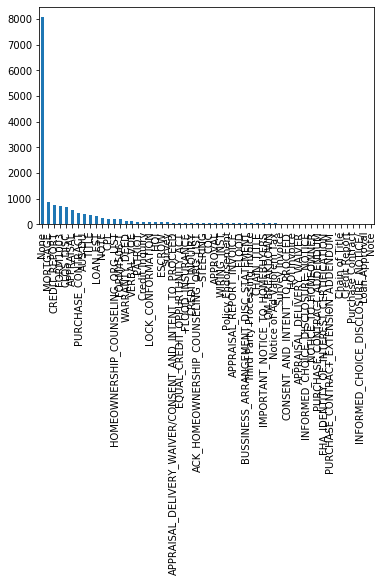

In [7]:
train_df['Label'].value_counts().plot(kind='bar')

In [8]:
train_df['Label'].value_counts()

None                                                       8065
MORTGAGE                                                    891
CREDIT_REPORT                                               754
FORM1003                                                    716
CLOS_DISC                                                   676
APPRAISAL                                                   571
PURCHASE_CONTRACT                                           449
AUS-DU                                                      393
TITLE                                                       383
LOAN_EST                                                    319
NOTE                                                        239
CPL                                                         225
HOMEOWNERSHIP_COUNSELING_ORG_LIST                           222
FORM4506-T                                                  218
WARRANTY_DEED                                               131
VERBAL_VOE                              

In [9]:
train_df.drop(train_df.loc[train_df['Label']=="-"].index, inplace=True)

In [10]:
train_df['Label'].value_counts()

None                                                       8065
MORTGAGE                                                    891
CREDIT_REPORT                                               754
FORM1003                                                    716
CLOS_DISC                                                   676
APPRAISAL                                                   571
PURCHASE_CONTRACT                                           449
AUS-DU                                                      393
TITLE                                                       383
LOAN_EST                                                    319
NOTE                                                        239
CPL                                                         225
HOMEOWNERSHIP_COUNSELING_ORG_LIST                           222
FORM4506-T                                                  218
WARRANTY_DEED                                               131
VERBAL_VOE                              

In [11]:
# Lets create training dataset for binary classification which will separate None type from other classes
None_df = train_df[train_df['Label'] == "None"]
other_df = train_df[train_df['Label'] != "None"]

In [12]:
None_df.head(2)

,Label,Text
8065,None,UWMEffective Date:23-Jan-18Lock Hours: 10:30 A...
8066,None,HUD/IVA Addendum to Uniform Residential Loan A...


In [13]:
other_df.head(2)

,Label,Text
0,CLOS_DISC,Closing DisclosureThis form is a statement of ...
1,CLOS_DISC,Closing Cost DetailsBorrower-PaidSeller-PaldLo...


In [14]:
None_df['Label'] = 0
other_df['Label']= 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
None_df.head(2)

,Label,Text
8065,0,UWMEffective Date:23-Jan-18Lock Hours: 10:30 A...
8066,0,HUD/IVA Addendum to Uniform Residential Loan A...


In [16]:
other_df.head(2)

,Label,Text
0,1,Closing DisclosureThis form is a statement of ...
1,1,Closing Cost DetailsBorrower-PaidSeller-PaldLo...


In [17]:
print(len(None_df))
print(len(other_df))

8065
8061


# Now it seemed balanced

In [18]:
final_binary_train_df = None_df.append(other_df)

In [19]:
final_binary_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16126 entries, 8065 to 8064
Data columns (total 2 columns):
Label    16126 non-null int64
Text     16126 non-null object
dtypes: int64(1), object(1)
memory usage: 378.0+ KB


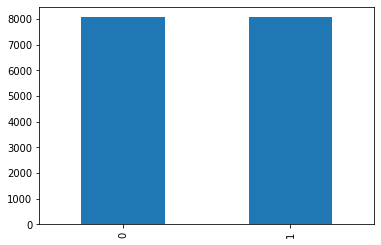

In [20]:
final_binary_train_df['Label'].value_counts().plot(kind='bar')

In [21]:
final_binary_train_df['processed_Text'] = final_binary_train_df['Text'].apply(clean)

In [22]:
final_binary_train_df.drop(['Text'], axis=1, inplace=True)

In [23]:
lb = LabelBinarizer()
lb.fit(final_binary_train_df['Label'])
lb.classes_

array([0, 1], dtype=int64)

In [24]:
train_b, test_b = train_test_split(final_binary_train_df, test_size=0.2, stratify=final_binary_train_df['Label'], random_state=42)

In [25]:
X_train_b_raw = train_b['processed_Text'].copy()
X_test_b_raw = test_b['processed_Text'].copy()
y_train_b = lb.transform(train_b['Label'])
y_test_b = lb.transform(test_b['Label'])

In [26]:
tokenizer_b = Tokenizer()
tokenizer_b.fit_on_texts(X_train_b_raw)

In [69]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train_b_raw)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [70]:
X_train_b = vectorizer.transform(X_train_b_raw)
X_test_b  = vectorizer.transform(X_test_b_raw)

In [71]:
X_train_b

<12900x133135 sparse matrix of type '<class 'numpy.int64'>'
	with 1517028 stored elements in Compressed Sparse Row format>

In [72]:
X_test_b

<3226x133135 sparse matrix of type '<class 'numpy.int64'>'
	with 354831 stored elements in Compressed Sparse Row format>

In [27]:
X_train_b = tokenizer_b.texts_to_matrix(X_train_b_raw, mode='tfidf')
X_test_b = tokenizer_b.texts_to_matrix(X_test_b_raw, mode='tfidf')

In [28]:
X_train_b.shape

(12900, 133160)

In [29]:
X_test_b.shape

(3226, 133160)

In [60]:
X_train_b = X_train_b[:,0:1000]
X_test_b = X_test_b[:,0:1000]

In [61]:
X_train_b.shape

(12900, 1000)

In [62]:
X_test_b.shape

(3226, 1000)

In [89]:

def binaryModel():
    model = Sequential()
    model.add(Dense(50, input_shape=(X_train_b.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [90]:

%%time
model = binaryModel()
history = model.fit(X_train_b, y_train_b, batch_size=1024, epochs=100, verbose=1)

Epoch 1/100
13/13 [==============================] - 1s 112ms/step - loss: 0.6003 - accuracy: 0.6964
Epoch 2/100
13/13 [==============================] - 1s 108ms/step - loss: 0.3542 - accuracy: 0.8988
Epoch 3/100
13/13 [==============================] - 1s 104ms/step - loss: 0.2240 - accuracy: 0.9394
Epoch 4/100
13/13 [==============================] - 1s 103ms/step - loss: 0.1547 - accuracy: 0.9590
Epoch 5/100
13/13 [==============================] - 1s 102ms/step - loss: 0.1219 - accuracy: 0.9669
Epoch 6/100
13/13 [==============================] - 1s 95ms/step - loss: 0.0913 - accuracy: 0.9754
Epoch 7/100
13/13 [==============================] - 1s 97ms/step - loss: 0.0800 - accuracy: 0.9764
Epoch 8/100
13/13 [==============================] - 1s 96ms/step - loss: 0.0626 - accuracy: 0.9822
Epoch 9/100
13/13 [==============================] - 1s 97ms/step - loss: 0.0564 - accuracy: 0.9822
Epoch 10/100
13/13 [==============================] - 1s 99ms/step - loss: 0.0494 - accuracy: 0

13/13 [==============================] - 1s 100ms/step - loss: 0.0180 - accuracy: 0.9907
Epoch 82/100
13/13 [==============================] - 1s 100ms/step - loss: 0.0203 - accuracy: 0.9912
Epoch 83/100
13/13 [==============================] - 1s 98ms/step - loss: 0.0191 - accuracy: 0.9902
Epoch 84/100
13/13 [==============================] - 1s 100ms/step - loss: 0.0185 - accuracy: 0.9908
Epoch 85/100
13/13 [==============================] - 1s 105ms/step - loss: 0.0171 - accuracy: 0.9898
Epoch 86/100
13/13 [==============================] - 1s 101ms/step - loss: 0.0180 - accuracy: 0.9912
Epoch 87/100
13/13 [==============================] - 1s 99ms/step - loss: 0.0160 - accuracy: 0.9906
Epoch 88/100
13/13 [==============================] - 1s 98ms/step - loss: 0.0175 - accuracy: 0.9912
Epoch 89/100
13/13 [==============================] - 1s 104ms/step - loss: 0.0176 - accuracy: 0.9902
Epoch 90/100
13/13 [==============================] - 1s 101ms/step - loss: 0.0182 - accuracy: 0.9

In [91]:
print(f"Training accuracy: {np.mean(history.history['accuracy']):.2}%")

Training accuracy: 0.98%


In [92]:
# Test data
scores = model.evaluate(X_test_b, y_test_b, verbose=0)
print(f"Test accuracy: {scores[1]:.2}%")

Test accuracy: 0.94%


In [93]:
y_hat_test = [lb.classes_[pred] for pred in model.predict_classes(X_test_b)]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


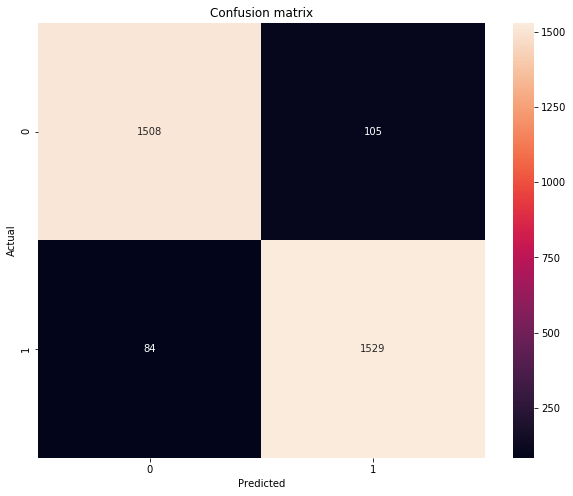

In [95]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test_b, y_hat_test), 
            annot=True, fmt='',
            xticklabels=lb.classes_,
            yticklabels=lb.classes_, ax=ax)
ax.set(title='Confusion matrix', xlabel='Predicted', ylabel='Actual')
plt.show()

## Lest do multi classificaiton now

In [100]:
multi_train_df = train_df[train_df['Label'] != 'None']

In [101]:
multi_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8061 entries, 0 to 8064
Data columns (total 2 columns):
Label    8061 non-null object
Text     8061 non-null object
dtypes: object(2)
memory usage: 188.9+ KB


In [102]:
multi_train_df['Label'].value_counts()

MORTGAGE                                                   891
CREDIT_REPORT                                              754
FORM1003                                                   716
CLOS_DISC                                                  676
APPRAISAL                                                  571
PURCHASE_CONTRACT                                          449
AUS-DU                                                     393
TITLE                                                      383
LOAN_EST                                                   319
NOTE                                                       239
CPL                                                        225
HOMEOWNERSHIP_COUNSELING_ORG_LIST                          222
FORM4506-T                                                 218
WARRANTY_DEED                                              131
VERBAL_VOE                                                 123
PATRIOT                                                

In [114]:
max_count = 891

In [103]:
groups = multi_train_df.groupby('Label')

In [115]:
#Lets write some logic to create a balanced df
balanced_df = multi_train_df[multi_train_df['Label']=='MORTGAGE']

In [132]:
def replicate(df):
    ndf = df
    while len(ndf) < 800:
        ndf = ndf.append(df)
    return ndf  

In [133]:
for g in groups:
    if g[0] != 'MORTGAGE' and len(g[1]) < 600:
        print(f"Started for {g[0]}")
        balanced_df = balanced_df.append(replicate(g[1]))

Started for ACK_HOMEOWNERSHIP_COUNSELING_ORG_LIST
Started for APPRAISAL
Started for APPRAISAL_DELIVERY_WAIVER
Started for APPRAISAL_DELIVERY_WAIVER/CONSENT_AND_INTENT_TO_PROCEED
Started for APPRAISAL_REPORT_INVOICE
Started for APPROVAL
Started for AUS-DU
Started for BUSSINESS_ARRANGEMENT_DISC_STATEMENT
Started for CHAIN_TITLE
Started for COC
Started for CONSENT_AND_INTENT_TO_PROCEED
Started for CPL
Started for CREDIT_INQUIRY
Started for Chain of Title
Started for Credit Inquiry
Started for Credit Report
Started for EQUAL_CREDIT_OPPURTUNITY_ACT
Started for ESCROW
Started for FHA_IDENTITY_OF_INTEREST_CERTIFICATION
Started for FLOOD
Started for FLOOD_INSURANCE
Started for FORM4506-T
Started for HOI
Started for HOI Invoice
Started for HOMEOWNERSHIP_COUNSELING_ORG_LIST
Started for IMPORTANT_NOTICE_TO_HOMEBUYERS
Started for INFORMED_CHOICE_DISCLOSURE_NOTICE
Started for INFORMED_CHOICE_DISCLOSURE_NOTICE/
Started for LOAN_EST
Started for LOCK_CONFORMATION
Started for Loan Approval
Started for 

In [134]:
balanced_df['Label'].value_counts()

AUS-DU                                                     1179
TITLE                                                      1149
APPRAISAL                                                  1142
LOAN_EST                                                    957
NOTE                                                        956
WARRANTY_DEED                                               917
CPL                                                         900
PURCHASE_CONTRACT                                           898
MORTGAGE                                                    891
HOMEOWNERSHIP_COUNSELING_ORG_LIST                           888
FORM4506-T                                                  872
APPRAISAL_DELIVERY_WAIVER/CONSENT_AND_INTENT_TO_PROCEED     864
VERBAL_VOE                                                  861
FLOOD                                                       855
BUSSINESS_ARRANGEMENT_DISC_STATEMENT                        855
STEERING                                

In [135]:
# Looks better now
balanced_df = balanced_df.sample(frac = 1)

In [136]:
balanced_df.reset_index(drop=True, inplace=True)

In [137]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43723 entries, 0 to 43722
Data columns (total 2 columns):
Label    43723 non-null object
Text     43723 non-null object
dtypes: object(2)
memory usage: 683.3+ KB


In [138]:
balanced_df.head()

,Label,Text
0,LOCK_CONFORMATION,Date: 03/01/2017 11:49 amAccount Executive Jul...
1,APPRAISAL_REPORT_INVOICE,INVOICEClass Appraisal2600 Bellingham Rd Suite...
2,IMPORTANT_NOTICE_TO_HOMEBUYERS,11/30/2018 2:45:25 PM MSTReviewAffiliated Busi...
3,APPRAISAL_DELIVERY_WAIVER,docutechACCELERATING DIGITAL LENDING.eSign Pro...
4,AUS-DU,"10/9/2018Desktop Underwriter Findings, Luis Em..."


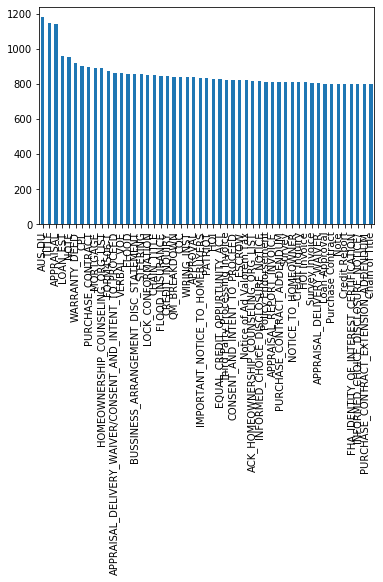

In [139]:
balanced_df['Label'].value_counts().plot(kind='bar')

In [141]:
balanced_df['processed_Text'] = balanced_df['Text'].apply(clean)

In [142]:
balanced_df.drop(['Text'], axis=1, inplace=True)

In [144]:
mlb = LabelBinarizer()
mlb.fit(balanced_df['Label'])
mlb.classes_

array(['ACK_HOMEOWNERSHIP_COUNSELING_ORG_LIST', 'APPRAISAL',
       'APPRAISAL_DELIVERY_WAIVER',
       'APPRAISAL_DELIVERY_WAIVER/CONSENT_AND_INTENT_TO_PROCEED',
       'APPRAISAL_REPORT_INVOICE', 'APPROVAL', 'AUS-DU',
       'BUSSINESS_ARRANGEMENT_DISC_STATEMENT', 'CHAIN_TITLE', 'COC',
       'CONSENT_AND_INTENT_TO_PROCEED', 'CPL', 'CREDIT_INQUIRY',
       'Chain of Title', 'Credit Inquiry', 'Credit Report',
       'EQUAL_CREDIT_OPPURTUNITY_ACT', 'ESCROW',
       'FHA_IDENTITY_OF_INTEREST_CERTIFICATION', 'FLOOD',
       'FLOOD_INSURANCE', 'FORM4506-T', 'HOI', 'HOI Invoice',
       'HOMEOWNERSHIP_COUNSELING_ORG_LIST',
       'IMPORTANT_NOTICE_TO_HOMEBUYERS',
       'INFORMED_CHOICE_DISCLOSURE_NOTICE',
       'INFORMED_CHOICE_DISCLOSURE_NOTICE/', 'LOAN_EST',
       'LOCK_CONFORMATION', 'Loan Approval', 'MORTGAGE', 'NOTE',
       'NOTICE_TO_HOMEOWNER', 'Note', 'Notice of Ad Valorem Tax',
       'PATRIOT', 'PURCHASE_CONTRACT', 'PURCHASE_CONTRACT_ADDENDUM',
       'PURCHASE_CONTRACT_EXTEN

In [145]:
train_m, test_m = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['Label'], random_state=42)

In [146]:
X_train_m_raw = train_m['processed_Text'].copy()
X_test_m_raw = test_m['processed_Text'].copy()
y_train_m = mlb.transform(train_m['Label'])
y_test_m = mlb.transform(test_m['Label'])

In [147]:
m_vectorizer = CountVectorizer()
m_vectorizer.fit(X_train_m_raw)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [148]:
X_train_m = m_vectorizer.transform(X_train_m_raw)
X_test_m  = m_vectorizer.transform(X_test_m_raw)

In [151]:
X_train_m.shape

(34978, 58160)

In [152]:
def multiClassModel():
    model = Sequential()
    model.add(Dense(50, input_shape=(X_train_m.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(len(mlb.classes_)))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [153]:
%%time
multi_model = multiClassModel()
multi_history = multi_model.fit(X_train_m, y_train_m, batch_size=1024, epochs=100, verbose=1)

Epoch 1/100
35/35 [==============================] - 3s 75ms/step - loss: 3.3512 - accuracy: 0.1469
Epoch 2/100
35/35 [==============================] - 3s 74ms/step - loss: 2.3305 - accuracy: 0.3653
Epoch 3/100
35/35 [==============================] - 3s 74ms/step - loss: 1.7384 - accuracy: 0.5088
Epoch 4/100
35/35 [==============================] - 3s 75ms/step - loss: 1.3698 - accuracy: 0.6015
Epoch 5/100
35/35 [==============================] - 3s 75ms/step - loss: 1.1680 - accuracy: 0.6592
Epoch 6/100
35/35 [==============================] - 3s 76ms/step - loss: 1.0183 - accuracy: 0.6961
Epoch 7/100
35/35 [==============================] - 3s 74ms/step - loss: 0.9187 - accuracy: 0.7263
Epoch 8/100
35/35 [==============================] - 3s 76ms/step - loss: 0.8497 - accuracy: 0.7458
Epoch 9/100
35/35 [==============================] - 3s 74ms/step - loss: 0.7971 - accuracy: 0.7602
Epoch 10/100
35/35 [==============================] - 3s 76ms/step - loss: 0.7466 - accuracy: 0.7761

Epoch 82/100
35/35 [==============================] - 3s 73ms/step - loss: 0.2617 - accuracy: 0.9260
Epoch 83/100
35/35 [==============================] - 3s 74ms/step - loss: 0.2619 - accuracy: 0.9238
Epoch 84/100
35/35 [==============================] - 3s 72ms/step - loss: 0.2620 - accuracy: 0.9267
Epoch 85/100
35/35 [==============================] - 3s 74ms/step - loss: 0.2584 - accuracy: 0.9269
Epoch 86/100
35/35 [==============================] - 3s 73ms/step - loss: 0.2676 - accuracy: 0.9243
Epoch 87/100
35/35 [==============================] - 3s 84ms/step - loss: 0.2554 - accuracy: 0.9273
Epoch 88/100
35/35 [==============================] - 3s 78ms/step - loss: 0.2607 - accuracy: 0.9256
Epoch 89/100
35/35 [==============================] - 3s 82ms/step - loss: 0.2487 - accuracy: 0.9291
Epoch 90/100
35/35 [==============================] - 3s 79ms/step - loss: 0.2539 - accuracy: 0.9284
Epoch 91/100
35/35 [==============================] - 3s 83ms/step - loss: 0.2583 - accurac

In [154]:
print(f"Training accuracy: {np.mean(multi_history.history['accuracy']):.2}%")

Training accuracy: 0.87%


In [156]:
# Test data
scores1 = multi_model.evaluate(X_test_m, y_test_m, verbose=0)
print(f"Test accuracy: {scores1[1]:.2}%")

Test accuracy: 1.0%


In [157]:
y_hat_test = [mlb.classes_[pred] for pred in multi_model.predict_classes(X_test_m)]

In [184]:
len(y_hat_test)

8745

In [185]:
y_test_m_label = [mlb.classes_[np.argmax(actual)] for actual in y_test_m]

In [186]:
len(y_test_m_label)

8745

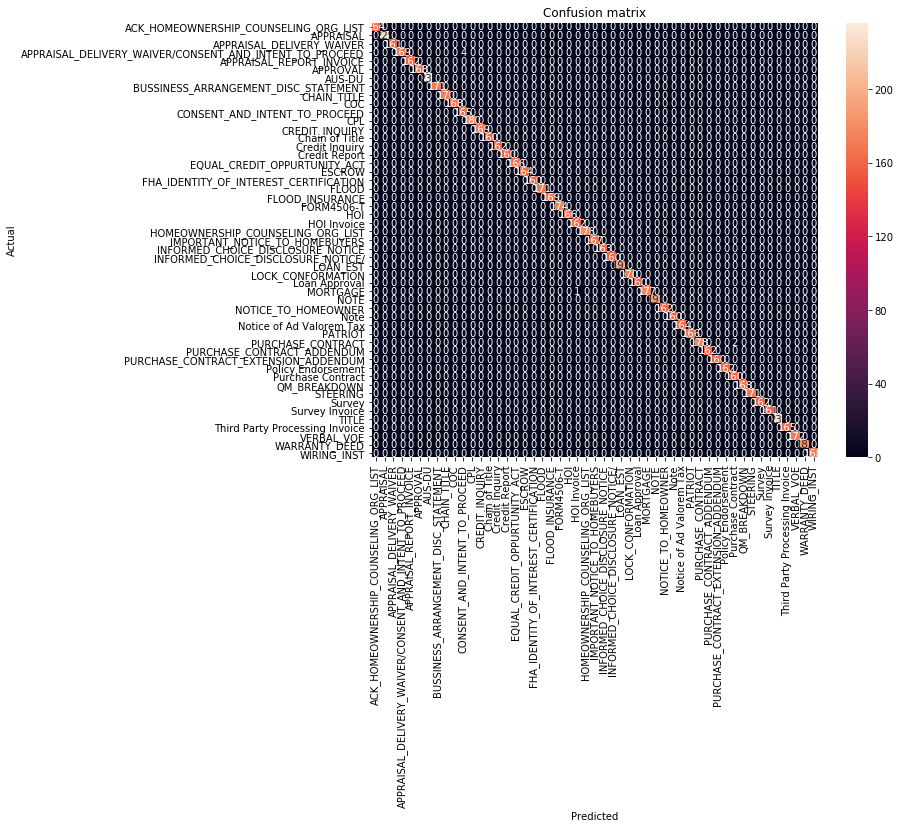

In [187]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test_m_label, y_hat_test), 
            annot=True, fmt='',
            xticklabels=mlb.classes_,
            yticklabels=mlb.classes_, ax=ax)
ax.set(title='Confusion matrix', xlabel='Predicted', ylabel='Actual')
plt.show()

# Let take a test data set and do prediction

In [188]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5464 entries, 0 to 5463
Data columns (total 1 columns):
Text    5464 non-null object
dtypes: object(1)
memory usage: 42.8+ KB


In [189]:
test_df.head()

,Text
0,TRUE & CERTIFIED COPYDAThis form is a statemen...
1,Additional Information About This LoanLoan Dis...
2,Closing Cost DetailsBorrower-PaidSeller-PaidPa...
3,Calculating Cash to CloseUse this table to see...
4,Loan CalculationsOther DisclosuresTotal of Pay...


In [221]:
def predictor(text):
    text = clean(text)
    text_b = vectorizer.transform([text])
    prediction = lb.classes_[model.predict_classes(text_b)]
    predicted_class = None
    if np.ravel(prediction)[0] == 0:
        predicted_class = "None"
    else:
        text_m = m_vectorizer.transform([text]) 
        m_prediction = mlb.classes_[multi_model.predict_classes(text_m)]
        predicted_class = m_prediction[0]
    return predicted_class

In [230]:
dummy_text = test_df['Text'].iloc[101]

In [231]:
predictor(dummy_text)

'CREDIT_INQUIRY'

In [233]:
test_df['Prediction'] = test_df['Text'].apply(predictor)

In [234]:
test_df.head()

,Text,Prediction
0,TRUE & CERTIFIED COPYDAThis form is a statemen...,LOAN_EST
1,Additional Information About This LoanLoan Dis...,NOTE
2,Closing Cost DetailsBorrower-PaidSeller-PaidPa...,NOTE
3,Calculating Cash to CloseUse this table to see...,NOTE
4,Loan CalculationsOther DisclosuresTotal of Pay...,NOTE


In [235]:
test_df.tail()

,Text,Prediction
5459,"Form W-9 (Rev. 11-2017)Page 51. Interest, divi...",None
5460,Closing DisclosureClosing InformationTransacti...,None
5461,Closing Cost DetailsSeller PaidLoan CostsAt Cl...,None
5462,Closing Disclosure Addendum ATransaction Infor...,None
5463,CLOSING DISCLOSURE RECEIPT ACKNOWLEDGEMENTSell...,None


In [237]:
test_df.to_excel("data/Result1.xlsx")